# 写真を利用した興味推定と観光地推薦への応用 (demo)

ディープラーニングによる画像認識を利用して、個人の記録された写真から興味を推定します。
推定された嗜好から、観光地を推薦します。

In [ ]:
import os
 
path = 'D:\\dataset\\demo\\photo_recommendation\\user1'
 
filelist = []
    
for d in os.listdir(path):
    if os.path.isdir(os.path.join(path, d)):
        subpath = os.path.join(path, d)
        for imgf in os.listdir(subpath):
            if os.path.isfile(os.path.join(subpath, imgf)):
                filelist.append(imgf)
 
# print(filelist)

# 1. 転移学習

学習済のニューラルネットワークVGG16を用いて転移学習をします。
転移学習の画像には、Caltech 256などのデータを用います。分類カテゴリは、5つです。['duck','elk','grape','rose','scene']

(参考)転移学習
https://qiita.com/God_KonaBanana/items/2cf829172087d2423f58

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Input
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import CSVLogger

In [ ]:
n_categories=5
batch_size=32
train_dir='D:\\dataset\\demo\photo_recommendation\\data\\train'
validation_dir='D:\\dataset\\demo\\photo_recommendation\\data\\validation'
file_name='vgg16_madomagi_fine'

base_model=VGG16(weights='imagenet',include_top=False,
                 input_tensor=Input(shape=(224,224,3)))

#add new layers instead of FC networks
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
prediction=Dense(n_categories,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=prediction)

#fix weights before VGG16 14layers
for layer in base_model.layers[:15]:
    layer.trainable=False

model.compile(optimizer=SGD(lr=0.0001,momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________

In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen=ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator=validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

hist=model.fit_generator(train_generator,
                         epochs=50,
                         verbose=1,
                         validation_data=validation_generator,
                         callbacks=[CSVLogger(file_name+'.csv')])



Found 347 images belonging to 5 classes.
Found 100 images belonging to 5 classes.

Epoch 1/50
11/11 [==============================] - 165s 15s/step - loss: 1.7564 - accuracy: 0.1614 - val_loss: 1.7073 - val_accuracy: 0.2200
Epoch 2/50
11/11 [==============================] - 156s 14s/step - loss: 1.6438 - accuracy: 0.2017 - val_loss: 1.4985 - val_accuracy: 0.3100
Epoch 3/50
11/11 [==============================] - 137s 12s/step - loss: 1.5670 - accuracy: 0.3112 - val_loss: 1.5638 - val_accuracy: 0.2800
Epoch 4/50
11/11 [==============================] - 165s 15s/step - loss: 1.5410 - accuracy: 0.3458 - val_loss: 1.5925 - val_accuracy: 0.3500
Epoch 5/50
11/11 [==============================] - 167s 15s/step - loss: 1.5215 - accuracy: 0.4323 - val_loss: 1.5091 - val_accuracy: 0.3900
Epoch 6/50
11/11 [==============================] - 179s 16s/step - loss: 1.5033 - accuracy: 0.4582 - val_loss: 1.5439 - val_accuracy: 0.4100
Epoch 7/50
11/11 [==============================] - 166s 15s/step

In [ ]:
#save weights
model.save(file_name+'.h5')

# 2. モデルの評価

転移学習したニューラルネットワークの評価をします。

Found 50 images belonging to 5 classes.

 test loss: 0.44770416617393494

 test_acc: 0.8199999928474426


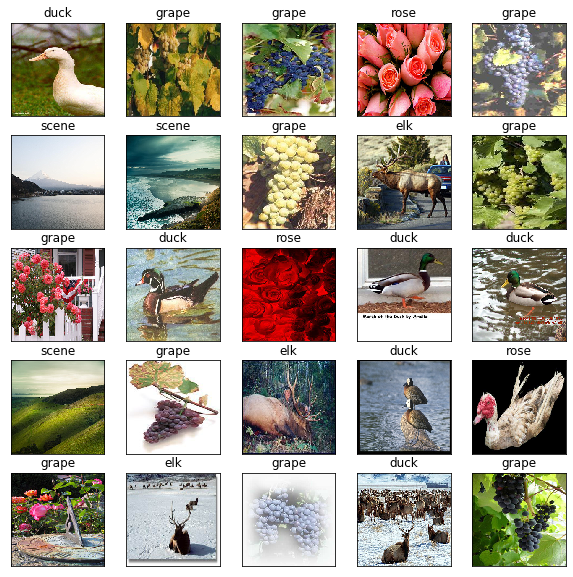

In [ ]:
from keras.models import model_from_json
import matplotlib.pyplot as plt
import numpy as np
import os,random
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

batch_size=32
file_name='vgg16_madomagi_fine'
test_dir='D:\\dataset\\demo\\photo_recommendation\\data\\test'
display_dir='D:\\dataset\\demo\photo_recommendation\\data\\display'
label=['duck','elk','grape','rose','scene']

#load model and weights
#json_string=open(file_name+'.json').read()
#model=model_from_json(json_string)
model.load_weights(file_name+'.h5')

model.compile(optimizer=SGD(lr=0.0001,momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#data generate
test_datagen=ImageDataGenerator(rescale=1.0/255)

test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

#evaluate model
score=model.evaluate_generator(test_generator)
print('\n test loss:',score[0])
print('\n test_acc:',score[1])

#predict model and display images
files=os.listdir(display_dir)
#print(files)
img=random.sample(files,25)
#print(img)

plt.figure(figsize=(10,10))
for i in range(25):
    temp_img=load_img(os.path.join(display_dir,img[i]),target_size=(224,224))
    plt.subplot(5,5,i+1)
    plt.imshow(temp_img)
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))
    #predict image
    img_pred=model.predict(temp_img_array)
    plt.title(label[np.argmax(img_pred)])
    #eliminate xticks,yticks
    plt.xticks([]),plt.yticks([])


plt.show()

# 4. 実験データの準備

画像集合から、ユーザの特徴ベクトルと、観光地の特徴ベクトルを生成します。

ユーザ1の画像集合


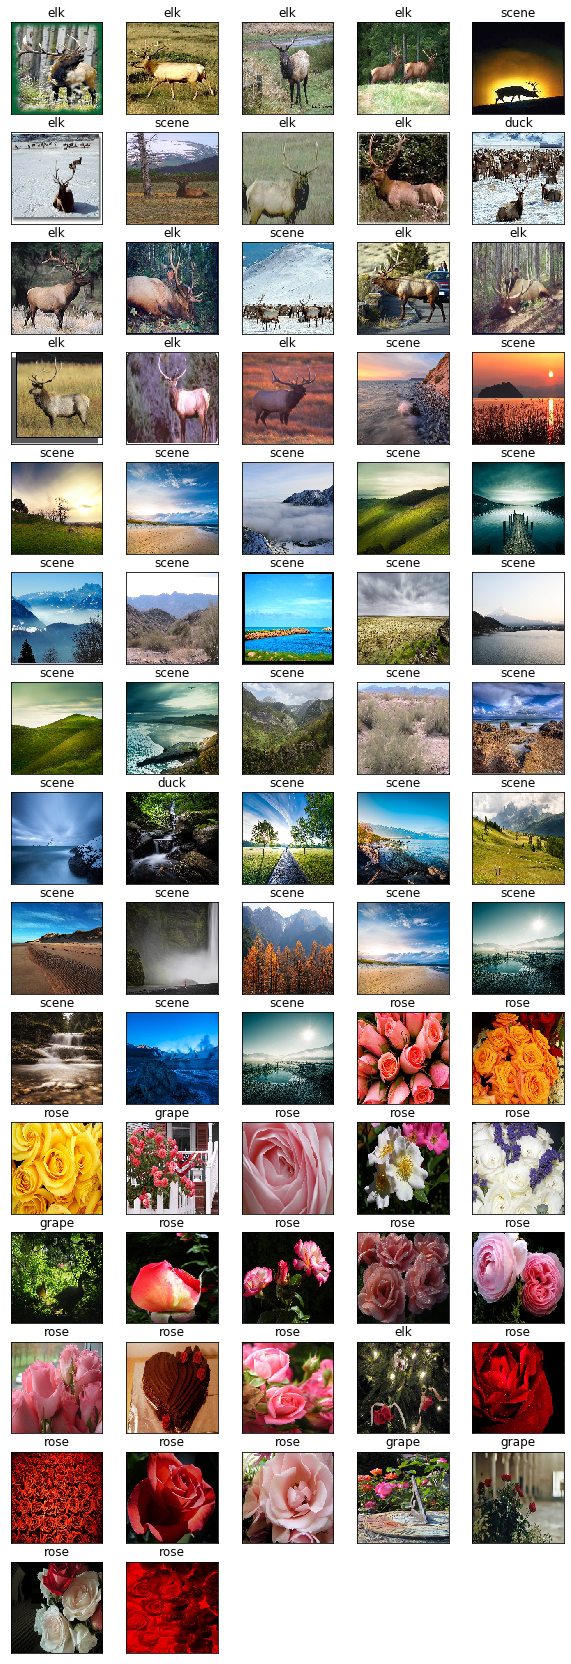

In [ ]:
user_dir = 'D:\\dataset\\demo\\photo_recommendation\\user1\\all'
    
#predict model and display images
files=os.listdir(user_dir)
#print(files)
#img=random.sample(files,25)
img = files

uvec = np.zeros(5)

print("ユーザ1の画像集合")

plt.figure(figsize=(10,30))
for i in range(len(img)):
    temp_img=load_img(os.path.join(user_dir,img[i]),target_size=(224,224))
    plt.subplot(len(img)/5 + 1,5,i+1)
    plt.imshow(temp_img)
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))
    #predict image
    img_pred=model.predict(temp_img_array)
    plt.title(label[np.argmax(img_pred)])
    #eliminate xticks,yticks
    plt.xticks([]),plt.yticks([])
    
    uvec[np.argmax(img_pred)] += 1


plt.show()

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'duck', 1: 'elk', 2: 'grape', 3: 'rose', 4: 'scene'}


In [ ]:
print(uvec)

[ 2. 15.  4. 19. 32.]


特徴ベクトルの平均値をとる。

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
from keras.models import Model

layer_name = 'dense_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

files=os.listdir(user_dir)
img = files

uvec_avr = np.zeros(1024)

for i in range(len(img)):
    temp_img=load_img(os.path.join(user_dir,img[i]),target_size=(224,224))
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))

    #extract vector
    intermediate_output = intermediate_layer_model.predict(temp_img_array)
    
    uvec_avr += intermediate_output[0]
    
    
uvec_avr = uvec_avr / len(img)
print (uvec_avr)

[0.         0.48496086 0.64140414 ... 0.02512401 0.         0.0076026 ]


In [ ]:
from keras.models import Model

place_dirs = ['D:\\dataset\\demo\\photo_recommendation\\place1\\all',
 'D:\\dataset\\demo\\photo_recommendation\\place2\\all',
 'D:\\dataset\\demo\\photo_recommendation\\place3\\all']

files=os.listdir(place_dirs[0])
img = files

places_avr = np.zeros((3, 1024))
places = np.zeros((3, 5))

for i in range(len(img)):
    temp_img=load_img(os.path.join(place_dirs[0],img[i]),target_size=(224,224))
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))

    # prediction
    img_pred=model.predict(temp_img_array)
    
    #extract vector
    intermediate_output = intermediate_layer_model.predict(temp_img_array)
    
    places_avr[0] += intermediate_output[0]
    
    places[0][np.argmax(img_pred)] += 1
    
places_avr[0] /= len(img)
    
files=os.listdir(place_dirs[1])
img = files

for i in range(len(img)):
    temp_img=load_img(os.path.join(place_dirs[1],img[i]),target_size=(224,224))
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))

    # prediction
    img_pred=model.predict(temp_img_array)
    
    #extract vector
    intermediate_output = intermediate_layer_model.predict(temp_img_array)
    
    places_avr[1] += intermediate_output[0]
    places[1][np.argmax(img_pred)] += 1
    
places_avr[1] /= len(img)
    
files=os.listdir(place_dirs[2])
img = files

for i in range(len(img)):
    temp_img=load_img(os.path.join(place_dirs[2],img[i]),target_size=(224,224))
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))

    # prediction
    img_pred=model.predict(temp_img_array)
    
    #extract vector
    intermediate_output = intermediate_layer_model.predict(temp_img_array)
    
    places_avr[2] += intermediate_output[0]
    places[2][np.argmax(img_pred)] += 1
    
places_avr[2] /= len(img)

In [ ]:
print (places_avr)
print (places)

[[0.00090284 0.5018639  0.44390537 ... 0.02717811 0.         0.23578336]
 [0.         0.31001588 0.59466021 ... 0.         0.         0.        ]
 [0.0100332  0.44617749 0.28580532 ... 0.         0.         0.0566499 ]]
[[ 2.  0. 15.  8.  0.]
 [ 1.  5.  0.  0.  9.]
 [ 9.  2.  8.  4.  2.]]


# (その1) カウントした特徴ベクトル

[0.04953774 0.37153305 0.09907548 0.47060853 0.79260385]
[[0.11684125 0.         0.87630936 0.46736499 0.        ]
 [0.09667365 0.48336824 0.         0.         0.87006284]
 [0.69230769 0.15384615 0.61538462 0.30769231 0.15384615]]
[0.31255478 0.87399143 0.4191655 ]
[0 2 1]


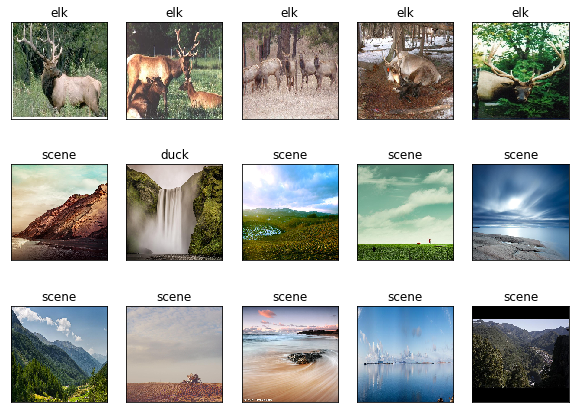

In [ ]:
from numpy import dot
from numpy.linalg import norm

print (uvec)
print (places)

uvec = uvec / norm(uvec)

places = places/np.linalg.norm(places, axis=1, keepdims=True) 

d2 = np.zeros(3)
d2[0] = np.sum(dot(places[0], uvec))
d2[1] = np.sum(dot(places[1], uvec))
d2[2] = np.sum(dot(places[2], uvec))

k=3
sorted_indexes = np.argsort(d2)
max_k = sorted_indexes[-(k+1):-1]
#min_k = sorted_indexes[:k+1]
        
print(d2)
print(sorted_indexes)

#predict model and display images
files=os.listdir(place_dirs[sorted_indexes[2]])
img = files

plt.figure(figsize=(10,10))
for i in range(len(img)):
    temp_img=load_img(os.path.join(place_dirs[sorted_indexes[2]],img[i]),target_size=(224,224))
    plt.subplot(len(img)/5 + 1,5,i+1)
    plt.imshow(temp_img)
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))
    #predict image
    img_pred=model.predict(temp_img_array)
    plt.title(label[np.argmax(img_pred)])
    #eliminate xticks,yticks
    plt.xticks([]),plt.yticks([])

plt.show()

# (その3)5次元特徴ベクトル

In [ ]:
# 5次元


files=os.listdir(user_dir)
img = files

uvec_avr5 = np.zeros(5)

for i in range(len(img)):
    temp_img=load_img(os.path.join(user_dir,img[i]),target_size=(224,224))
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))

    #extract vector
    output = model.predict(temp_img_array)
    
    uvec_avr5 += output[0]
    
    
uvec_avr5 = uvec_avr5 / len(img)
print (uvec_avr5)

[0.0951541  0.18288438 0.07288734 0.257088   0.39198618]


In [ ]:
place_dirs = ['D:\\dataset\\demo\\photo_recommendation\\place1\\all',
 'D:\\dataset\\demo\\photo_recommendation\\place2\\all',
 'D:\\dataset\\demo\\photo_recommendation\\place3\\all']

files=os.listdir(place_dirs[0])
img = files

places_avr5 = np.zeros((3, 5))

for i in range(len(img)):
    temp_img=load_img(os.path.join(place_dirs[0],img[i]),target_size=(224,224))
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))

    # prediction
    output=model.predict(temp_img_array)
    
    places_avr5[0] += output[0]
    
    
places_avr5[0] /= len(img)
    
files=os.listdir(place_dirs[1])
img = files

for i in range(len(img)):
    temp_img=load_img(os.path.join(place_dirs[1],img[i]),target_size=(224,224))
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))

    # prediction
    output=model.predict(temp_img_array)
    
    places_avr5[1] += output[0]
    
places_avr5[1] /= len(img)
    
files=os.listdir(place_dirs[2])
img = files

for i in range(len(img)):
    temp_img=load_img(os.path.join(place_dirs[2],img[i]),target_size=(224,224))
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))

    # prediction
    output=model.predict(temp_img_array)
    
    places_avr5[2] += output[0]
    
places_avr5[2] /= len(img)

print(places_avr5)

[[0.05634709 0.01152482 0.5670032  0.36125204 0.00387284]
 [0.12478544 0.25912614 0.03072402 0.02031871 0.56504568]
 [0.27565323 0.09612657 0.36958059 0.1526978  0.10594182]]


[0.41024072 0.87733766 0.57859076]
[0 2 1]


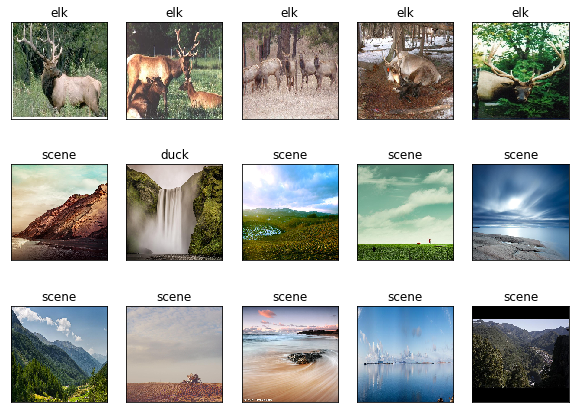

In [ ]:
from numpy import dot
from numpy.linalg import norm

uvec_avr5 = uvec_avr5 / norm(uvec_avr5)

places_avr5 = places_avr5/np.linalg.norm(places_avr5, axis=1, keepdims=True) 

d3 = np.zeros(3)
d3[0] = np.sum(dot(places_avr5[0], uvec_avr5))
d3[1] = np.sum(dot(places_avr5[1], uvec_avr5))
d3[2] = np.sum(dot(places_avr5[2], uvec_avr5))

k=3
sorted_indexes = np.argsort(d3)
max_k = sorted_indexes[-(k+1):-1]
#min_k = sorted_indexes[:k+1]

print(d3)
print(sorted_indexes)


#predict model and display images
files=os.listdir(place_dirs[sorted_indexes[2]])
img = files

plt.figure(figsize=(10,10))
for i in range(len(img)):
    temp_img=load_img(os.path.join(place_dirs[sorted_indexes[2]],img[i]),target_size=(224,224))
    plt.subplot(len(img)/5 + 1,5,i+1)
    plt.imshow(temp_img)
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))
    #predict image
    img_pred=model.predict(temp_img_array)
    plt.title(label[np.argmax(img_pred)])
    #eliminate xticks,yticks
    plt.xticks([]),plt.yticks([])

plt.show()

# (その3)1000次元特徴ベクトル

[0.93094673 0.97488572 0.98234779]
[0 1 2]


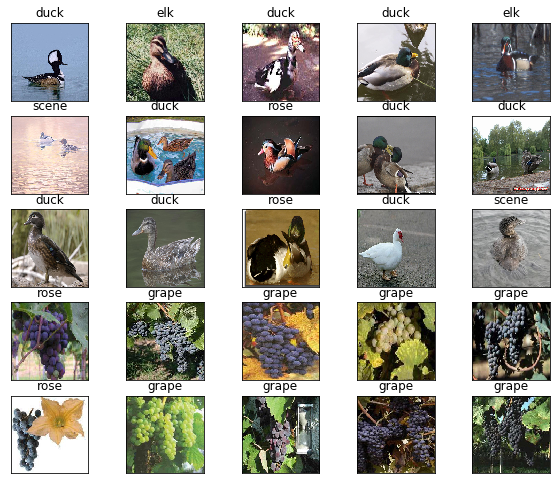

In [ ]:
from numpy import dot
from numpy.linalg import norm

uvec_avr = uvec_avr / norm(uvec_avr)

places_avr = places_avr/np.linalg.norm(places_avr, axis=1, keepdims=True) 

d = np.zeros(3)
d[0] = np.sum(dot(places_avr[0], uvec_avr))
d[1] = np.sum(dot(places_avr[1], uvec_avr))
d[2] = np.sum(dot(places_avr[2], uvec_avr))

k=3
sorted_indexes = np.argsort(d)
max_k = sorted_indexes[-(k+1):-1]
#min_k = sorted_indexes[:k+1]

print(d)
print(sorted_indexes)

#predict model and display images
files=os.listdir(place_dirs[sorted_indexes[2]])
img = files

plt.figure(figsize=(10,10))
for i in range(len(img)):
    temp_img=load_img(os.path.join(place_dirs[sorted_indexes[2]],img[i]),target_size=(224,224))
    plt.subplot(len(img)/5 + 1,5,i+1)
    plt.imshow(temp_img)
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))
    #predict image
    img_pred=model.predict(temp_img_array)
    plt.title(label[np.argmax(img_pred)])
    #eliminate xticks,yticks
    plt.xticks([]),plt.yticks([])

plt.show()

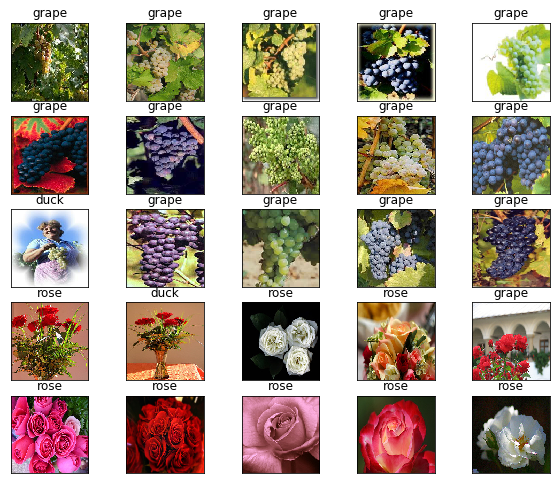

In [ ]:
#predict model and display images
files=os.listdir(place_dirs[0])
img = files

plt.figure(figsize=(10,10))
for i in range(len(img)):
    temp_img=load_img(os.path.join(place_dirs[0],img[i]),target_size=(224,224))
    plt.subplot(len(img)/5 + 1,5,i+1)
    plt.imshow(temp_img)
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))
    #predict image
    img_pred=model.predict(temp_img_array)
    plt.title(label[np.argmax(img_pred)])
    #eliminate xticks,yticks
    plt.xticks([]),plt.yticks([])

plt.show()